In [2]:
%cd /content/drive/MyDrive/CV_ENG_8160/Homeworks/HW2

/content/drive/MyDrive/CV_ENG_8160/Homeworks/HW2


In [3]:
import pandas as pd
import random, math
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from scipy import fftpack
import torch.utils.data as utils
import os
from sklearn.metrics import mean_absolute_percentage_error
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
from models import *

In [4]:
class TrafficForecast(Dataset):
    def __init__(self, pkl_path, window, horizon, train_size=0.8, mode='train'):
        self.pkl_path = pkl_path
        self.window = window
        self.horizon = horizon
        self.mode = mode
        self.df = None
        self.seg_ids = None
        self.inputs = []
        self.targets = []

        df = pd.read_pickle(self.pkl_path)
        df['time'] = pd.to_datetime(df['time'])
        df['unix_timestamp'] = df['time'].astype(int) / 10**9
        df['dow'] = df['time'].dt.weekday
        df['hour'] = df['time'].dt.hour
        df['min'] = df['time'].dt.minute
        self.df = df.sample(frac=1).reset_index(drop=True)

        self.seg_ids = self.df['segmentID'].unique()
        train_cutoff = int(len(self.seg_ids) * train_size)
        self.train_seg_ids = self.seg_ids[:train_cutoff]
        self.test_seg_ids = self.seg_ids[train_cutoff:]

        if self.mode == 'train':
            self.setup_forecast(self.train_seg_ids)
        elif self.mode == 'test':
            self.setup_forecast(self.test_seg_ids)

    def setup_forecast(self, seg_ids):

        for segid in seg_ids:

            df_seg_id = self.df[self.df['segmentID'] == segid]
            df_seg_id = df_seg_id.sort_values(by='time', ascending=True)
            df_seg_id = df_seg_id.fillna(method="ffill")
            TI_series = df_seg_id['TrafficIndex_GP'].values
            h_series = df_seg_id['hour'].values
            for t in range(len(TI_series) - (self.window + self.horizon)):
                x = TI_series[t:t+self.window]
                h = h_series[t:t+self.window]
                y = TI_series[t+self.window:(t+self.window + self.horizon)]

                x_combined = np.stack((x, h), axis=1)
                self.inputs.append(x_combined)
                self.targets.append(y)

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):
        X = torch.tensor(self.inputs[idx], dtype=torch.float32)

        y = torch.tensor(self.targets[idx], dtype=torch.float32)
        return {'inputs': X, 'outputs': y}




In [5]:
tobj_train = TrafficForecast('tps_df.pkl', 36, 12, train_size=0.8, mode='train')

tobj_test = TrafficForecast('tps_df.pkl', 36, 12, train_size=0.8, mode='test')

In [6]:
bs = 1024
dataloader_train = DataLoader(tobj_train, batch_size=1024, shuffle=False, num_workers=4, drop_last=True)

dataloader_test = DataLoader(tobj_test, batch_size=1024, shuffle=False, num_workers=4, drop_last=True)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [7]:
for idx, data in enumerate(dataloader_train):
    print (data['inputs'].shape,data['outputs'].shape)
    if idx == 3:
        break

torch.Size([1024, 36, 2]) torch.Size([1024, 12])
torch.Size([1024, 36, 2]) torch.Size([1024, 12])
torch.Size([1024, 36, 2]) torch.Size([1024, 12])
torch.Size([1024, 36, 2]) torch.Size([1024, 12])


In [8]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# LSTM

In [9]:
model = MyLSTM(n_inputs=2, n_hidden=10, n_rnnlayers=2, n_outputs=12)
model.to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [10]:
n_epochs = 5

mean_loss = []
mean_test_loss = []

for it in tqdm(range(n_epochs)):
    losses = []
    test_losses = []

    model.train()
    for i_batch, sample_batched in enumerate(dataloader_train):
        optimizer.zero_grad()
        outputs = model(sample_batched['inputs'].to(device))
        loss = criterion(outputs, sample_batched['outputs'].to(device))
        losses.append(loss.item())
        loss.backward()
        optimizer.step()

    epoch_mean_loss = np.mean(losses)
    mean_loss.append(epoch_mean_loss)

    model.eval()
    with torch.no_grad():
        for sample_batched in dataloader_test:
            outputs = model(sample_batched['inputs'].to(device))
            test_loss = criterion(outputs, sample_batched['outputs'].to(device))
            test_losses.append(test_loss.item())

    epoch_mean_test_loss = np.mean(test_losses)
    mean_test_loss.append(epoch_mean_test_loss)

    print(f'Epoch {it+1}/{n_epochs}, Training Loss: {epoch_mean_loss:.4f}, Test Loss: {epoch_mean_test_loss:.4f}')


  0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
 20%|██        | 1/5 [00:27<01:51, 27.95s/it]

Epoch 1/5, Training Loss: 0.0675, Test Loss: 0.0118


 40%|████      | 2/5 [00:55<01:23, 27.91s/it]

Epoch 2/5, Training Loss: 0.0117, Test Loss: 0.0116


 60%|██████    | 3/5 [01:27<00:58, 29.48s/it]

Epoch 3/5, Training Loss: 0.0114, Test Loss: 0.0114


 80%|████████  | 4/5 [01:55<00:28, 28.92s/it]

Epoch 4/5, Training Loss: 0.0103, Test Loss: 0.0114


100%|██████████| 5/5 [02:22<00:00, 28.43s/it]

Epoch 5/5, Training Loss: 0.0084, Test Loss: 0.0094


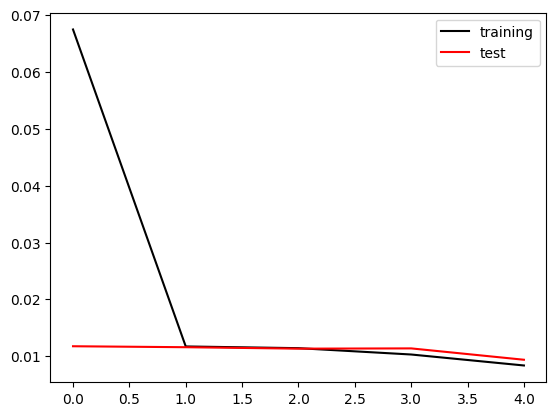

In [11]:
plt.plot(mean_loss,'k',label='training')
plt.plot(mean_test_loss,'r',label='test')
plt.legend()
plt.show()

In [12]:
def evaluation(model, dataloader_test, device):
    model.eval()
    mse_values = []
    mape_values = []

    with torch.no_grad():
        for sample_test in dataloader_test:
            inputs = sample_test['inputs'].to(device)
            targets = sample_test['outputs'].to(device)
            preds = model(inputs)

            mse = ((preds - targets) ** 2).mean().item()
            mape = (preds - targets).abs() / targets.abs()
            mape = mape.mean().item() * 100

            mse_values.append(mse)
            mape_values.append(mape)

    return {'mse': np.mean(mse_values), 'mape': np.mean(mape_values)}


In [13]:
results = evaluation(model,dataloader_test,bs)
print (results)

{'mse': 0.009404781787366584, 'mape': 8.23798223552624}


# GRU

In [23]:
model = MyGRU(n_inputs=2, n_hidden=10, n_rnnlayers=2, n_outputs=12)
model.to(device)

MyGRU(
  (relu): ReLU()
  (rnn): GRU(2, 10, num_layers=2, batch_first=True)
  (fc): Linear(in_features=10, out_features=12, bias=True)
)

In [24]:
n_epochs = 5
mean_loss = []
mean_test_loss = []
for it in tqdm(range(n_epochs)):
    losses = []
    test_losses = []

    model.train()
    for i_batch, sample_batched in enumerate(dataloader_train):
        optimizer.zero_grad()
        outputs = model(sample_batched['inputs'].to(device))
        loss = criterion(outputs, sample_batched['outputs'].to(device))
        losses.append(loss.item())
        loss.backward()
        optimizer.step()
    epoch_mean_loss = np.mean(losses)
    mean_loss.append(epoch_mean_loss)

    model.eval()
    with torch.no_grad():
        for sample_batched in dataloader_test:
            outputs = model(sample_batched['inputs'].to(device))
            test_loss = criterion(outputs, sample_batched['outputs'].to(device))
            test_losses.append(test_loss.item())

    epoch_mean_test_loss = np.mean(test_losses)
    mean_test_loss.append(epoch_mean_test_loss)

    print(f'Epoch {it+1}/{n_epochs}, Training Loss: {epoch_mean_loss:.4f}, Test Loss: {epoch_mean_test_loss:.4f}')

 20%|██        | 1/5 [00:27<01:48, 27.14s/it]

Epoch 1/5, Training Loss: 0.6764, Test Loss: 0.6838


 40%|████      | 2/5 [00:53<01:19, 26.58s/it]

Epoch 2/5, Training Loss: 0.6764, Test Loss: 0.6838


 60%|██████    | 3/5 [01:24<00:56, 28.48s/it]

Epoch 3/5, Training Loss: 0.6764, Test Loss: 0.6838


 80%|████████  | 4/5 [01:52<00:28, 28.45s/it]

Epoch 4/5, Training Loss: 0.6764, Test Loss: 0.6838


100%|██████████| 5/5 [02:20<00:00, 28.05s/it]

Epoch 5/5, Training Loss: 0.6764, Test Loss: 0.6838


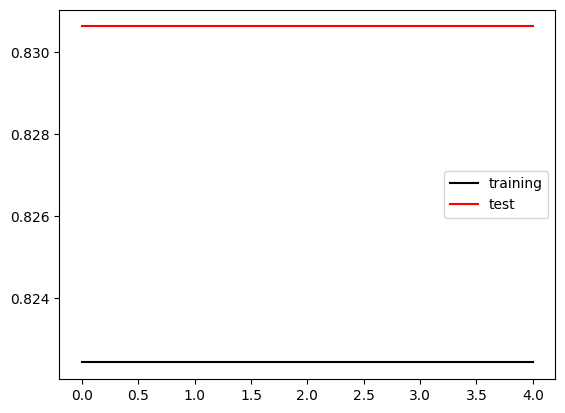

In [16]:
plt.plot(mean_loss,'k',label='training')
plt.plot(mean_test_loss,'r',label='test')
plt.legend()
plt.show()

In [25]:
results = evaluation(model,dataloader_test,bs)
print (results)

{'mse': 0.6837682437708997, 'mape': 82.20495813944208}


# RNN

In [17]:
model = MyRNN(input_size=2, hidden_size=10, num_layers=2, output_size=12)
model.to(device)

MyRNN(
  (rnn_cell_list): ModuleList(
    (0): MyRNNCell(
      (x2h): Linear(in_features=2, out_features=10, bias=True)
      (h2h): Linear(in_features=10, out_features=10, bias=True)
      (nonlinearity): ReLU()
    )
    (1-2): 2 x MyRNNCell(
      (x2h): Linear(in_features=10, out_features=10, bias=True)
      (h2h): Linear(in_features=10, out_features=10, bias=True)
      (nonlinearity): ReLU()
    )
  )
  (fc): Linear(in_features=10, out_features=12, bias=True)
)

In [18]:
learning_rate = 0.001
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [19]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [20]:
n_epochs = 5
mean_loss = []
mean_test_loss = []
for it in tqdm(range(n_epochs)):
    losses = []
    test_losses = []

    model.train()
    for i_batch, sample_batched in enumerate(dataloader_train):
        optimizer.zero_grad()
        outputs = model(sample_batched['inputs'].to(device))
        loss = criterion(outputs, sample_batched['outputs'].to(device))
        losses.append(loss.item())
        loss.backward()
        optimizer.step()
    epoch_mean_loss = np.mean(losses)
    mean_loss.append(epoch_mean_loss)

    model.eval()
    with torch.no_grad():
        for sample_batched in dataloader_test:
            outputs = model(sample_batched['inputs'].to(device))
            test_loss = criterion(outputs, sample_batched['outputs'].to(device))
            test_losses.append(test_loss.item())

    epoch_mean_test_loss = np.mean(test_losses)
    mean_test_loss.append(epoch_mean_test_loss)

    print(f'Epoch {it+1}/{n_epochs}, Training Loss: {epoch_mean_loss:.4f}, Test Loss: {epoch_mean_test_loss:.4f}')

 20%|██        | 1/5 [00:41<02:47, 41.88s/it]

Epoch 1/5, Training Loss: 0.1346, Test Loss: 0.0096


 40%|████      | 2/5 [01:23<02:05, 41.70s/it]

Epoch 2/5, Training Loss: 0.0090, Test Loss: 0.0095


 60%|██████    | 3/5 [02:04<01:22, 41.32s/it]

Epoch 3/5, Training Loss: 0.0086, Test Loss: 0.0091


 80%|████████  | 4/5 [02:47<00:41, 41.92s/it]

Epoch 4/5, Training Loss: 0.0082, Test Loss: 0.0086


100%|██████████| 5/5 [03:31<00:00, 42.27s/it]

Epoch 5/5, Training Loss: 0.0078, Test Loss: 0.0083


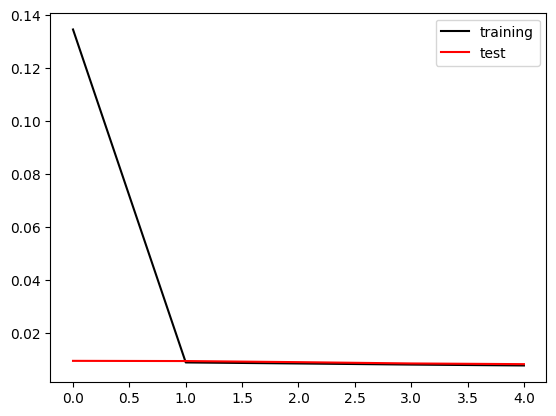

In [21]:
plt.plot(mean_loss,'k',label='training')
plt.plot(mean_test_loss,'r',label='test')
plt.legend()
plt.show()

In [22]:
results = evaluation(model,dataloader_test,bs)
print (results)

{'mse': 0.008334591287058983, 'mape': 6.968453812126921}
